In [227]:
import json
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nla
import pandas as pd
import scipy
import scipy.sparse as ssp
import scipy.linalg as sla
import sparse
from sparse import COO
import xarray as xr

In [4]:
ds0 = xr.open_dataset("CH4_EUROPE_PARIS_dec2023_weighted_2021-02-01.nc")

In [5]:
ds0

<xarray.Dataset>
Dimensions:            (nmeasure: 4074, nUI: 2, steps: 10000, nparam: 499,
                        nBC: 4, nsigma_site: 30, nsigma_time: 1, nsite: 30,
                        lat: 293, lon: 391, countrynames: 20, nlatent: 499)
Coordinates:
    stepnum            (steps) int64 ...
    paramnum           (nlatent) int64 ...
    numBC              (nBC) int64 ...
    measurenum         (nmeasure) int64 ...
    UInum              (nUI) int64 ...
    nsites             (nsite) int64 ...
  * nsigma_time        (nsigma_time) int64 0
  * nsigma_site        (nsigma_site) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
  * lat                (lat) float32 10.73 10.96 11.2 ... 78.59 78.82 79.06
  * lon                (lon) float32 -97.9 -97.55 -97.2 ... 38.68 39.03 39.38
  * countrynames       (countrynames) <U14 'None' 'RestEU' ... 'UNITED KINGDOM'
Dimensions without coordinates: nmeasure, nUI, steps, nparam, nBC, nsite,
                                nlatent
Data variables: (12/43)
    Yobs               (nmeasure) float64 ...
    Yerror             (nmeasure) float64 ...
    Ytime              (nmeasure) datetime64[ns] ...
    Yapriori           (nmeasure) float64 ...
    Ymodmean           (nmeasure) float64 ...
    Ymodmedian         (nmeasure) float64 ...
    ...                 ...
    country68          (countrynames, nUI) float64 ...
    country95          (countrynames, nUI) float64 ...
    countryapriori     (countrynames) float64 ...
    countrydefinition  (lat, lon) int32 ...
    xsensitivity       (nmeasure, nparam) float64 ...
    bcsensitivity      (nmeasure, nBC) float64 ...
Attributes: (12/15)
    Start date:           2021-02-01
    End date:             2021-03-01
    Latent sampler:       mc.nuts.NUTS 
    Hyper sampler:        licer.Slice o
    Burn in:              10000
    Tuning steps:         10000
    ...                   ...
    Model error Prior:    pdf,uniform,lower,0.1,upper,1.0
    BCs Prior:            pdf,truncatednormal,mu,1.0,sigma,0.1,lower,0.0
    Creator:              cv18710
    Date created:         2023-12-12 20:35:08.980406
    Convergence:          Passed
    Repository version:   Unknown

# Countries

In [19]:
country_path = Path("~/Documents/openghg_inversions/countries")

In [14]:
!ls $country_path

LICENSE		    openghg_inversions.egg-info  requirements-dev.txt  tests
README.md	    pyproject.toml		 requirements.txt
openghg_inversions  pytest.ini			 setup.py


In [20]:
cds = xr.open_dataset(country_path/"country_EUROPE.nc")

In [21]:
cds

<xarray.Dataset>
Dimensions:  (lat: 293, lon: 391, ncountries: 104)
Coordinates:
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
Dimensions without coordinates: ncountries
Data variables:
    country  (lat, lon) float64 ...
    name     (ncountries) <U52 ...
Attributes:
    title:     Grid of country extent across EUROPE domain
    author:    File created by ag12733
    database:  Natural_Earth database with scale 1:50m used to create this fi...
    extent:    Domain beween latitude 10.7290000916 - 79.0569992065, longitud...

In [23]:
cds_ukmo = xr.open_dataset(country_path/"country-ukmo_EUROPE.nc")

In [317]:
cds_ukmo

<xarray.Dataset>
Dimensions:  (lon: 391, lat: 293, ncountries: 20)
Coordinates:
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
Dimensions without coordinates: ncountries
Data variables:
    name     (ncountries) <U14 ...
    country  (lat, lon) int32 ...

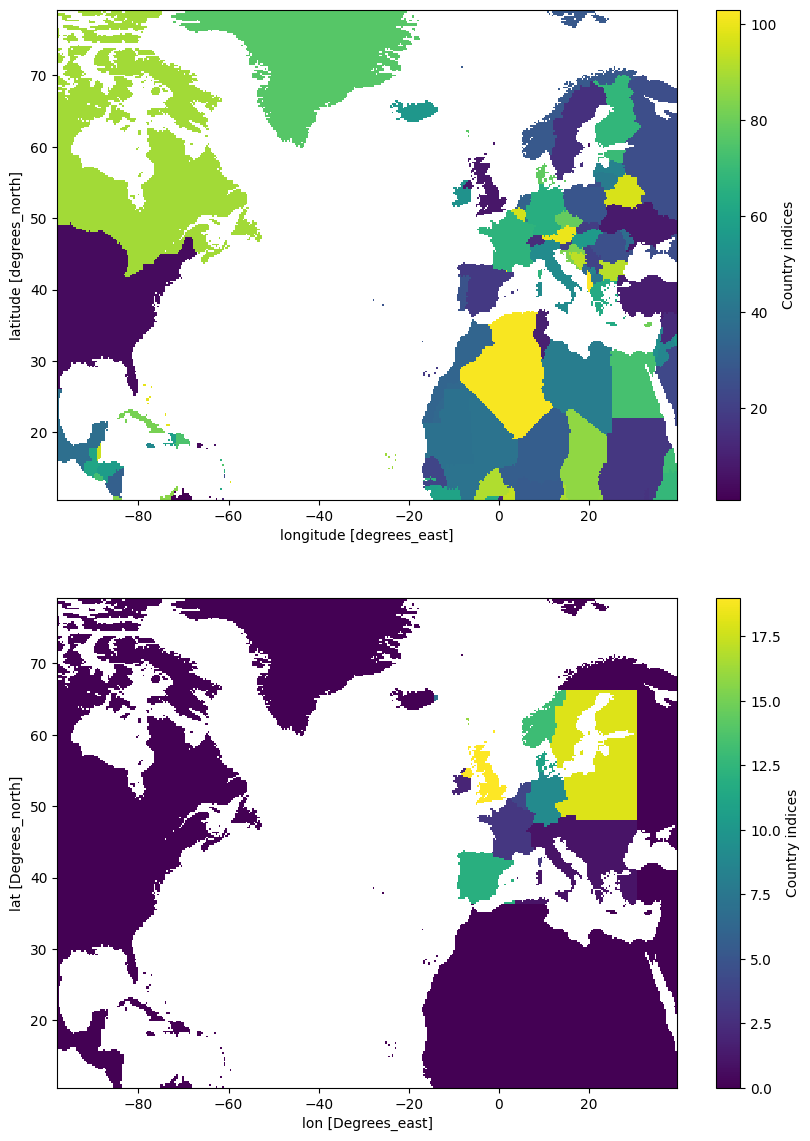

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 14))
cds.country.where(cds.country > 0).plot(ax=axs.flat[0])
cds_ukmo.country.where(cds.country > 0).plot(ax=axs.flat[1])

In [ ]:
cds

## Need country totals for 17 EU+UK countries

"ukmo" map lumps most EU countries together.

Steps for creating country maps:
1. get flux and basis functions
2. create a map from basis function scaling factors to scaling factors on original grid
3. generate trace in original grid
4. project original grid to countries:
    - scale grid cells by their area
    - multiply by grid-country matrix
5. convert units  

In [25]:
import openghg_inversions.utils as iutils

In [26]:
areagrid = xr.DataArray(iutils.areagrid(ds0.lat.values, ds0.lon.values), coords=[ds0.lat, ds0.lon], dims=["lat", "lon"], name="area_grid")

In [27]:
areagrid

<xarray.DataArray 'area_grid' (lat: 293, lon: 391)>
array([[9.99520492e+08, 9.99520492e+08, 9.99520492e+08, ...,
        9.99520492e+08, 9.99520492e+08, 9.99520492e+08],
       [9.98738733e+08, 9.98738733e+08, 9.98738733e+08, ...,
        9.98738733e+08, 9.98738733e+08, 9.98738733e+08],
       [9.97940271e+08, 9.97940271e+08, 9.97940271e+08, ...,
        9.97940271e+08, 9.97940271e+08, 9.97940271e+08],
       ...,
       [2.01269171e+08, 2.01269171e+08, 2.01269171e+08, ...,
        2.01269171e+08, 2.01269171e+08, 2.01269171e+08],
       [1.97194862e+08, 1.97194862e+08, 1.97194862e+08, ...,
        1.97194862e+08, 1.97194862e+08, 1.97194862e+08],
       [1.93117280e+08, 1.93117280e+08, 1.93117280e+08, ...,
        1.93117280e+08, 1.93117280e+08, 1.93117280e+08]])
Coordinates:
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38

In [28]:
flux = ds0.fluxapriori

In [29]:
flux

<xarray.DataArray 'fluxapriori' (lat: 293, lon: 391)>
[114563 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 10.73 10.96 11.2 11.43 ... 78.36 78.59 78.82 79.06
  * lon      (lon) float32 -97.9 -97.55 -97.2 -96.84 ... 38.32 38.68 39.03 39.38
Attributes:
    units:     mol/m2/s
    longname:  mean a priori flux over period

We need to make a map from flatten lat/lon to basis boxes.

The transpose of this, times the a priori flux, is how we map from the basis function space to the original state space.

In [294]:
%run country_totals.py

In [115]:
basis_mat = get_xr_dummies(ds0.basisfunctions.stack(loc=("lat", "lon")), cat_dim="basis_region", sparse=True)

In [296]:
basis_mat

Format,coo
Data Type,int64
Shape,"(114563, 499)"
nnz,114563
Density,0.002004008016032064
Read-only,True
Size,1.7M
Storage ratio,0.0


In [295]:
get_xr_dummies(ds0.basisfunctions, cat_dim="basis_region")

Format,coo
Data Type,int64
Shape,"(499, 293, 391)"
nnz,114563
Density,0.002004008016032064
Read-only,True
Size,2.2M
Storage ratio,0.0


In [130]:
country_mat = get_xr_dummies(ds0.countrydefinition.stack(loc=("lat", "lon")), cat_dim="country", categories=ds0.countrynames.values, sparse=True)

In [254]:
country_mat104 = get_xr_dummies(cds.country.stack(loc=("lat", "lon")), cat_dim="country", categories=cds.name.values, sparse=True)

In [119]:
area_flux = ssp.diags((areagrid * flux).values.flatten())

In [124]:
agfs = (areagrid * flux).stack(loc=("lat", "lon"))

In [125]:
agfs * basis_mat

Format,coo
Data Type,float64
Shape,"(114563, 499)"
nnz,110709
Density,0.001936591425214893
Read-only,True
Size,1.7M
Storage ratio,0.0


In [131]:
country_mat.T

Format,coo
Data Type,int64
Shape,"(20, 114563)"
nnz,114563
Density,0.05
Read-only,True
Size,1.7M
Storage ratio,0.1


In [255]:
x_to_country = (country_mat104 * agfs * basis_mat).sum("loc")

In [150]:
%%timeit
x_to_country1 = (country_mat * agfs * basis_mat).sum("loc")

41.8 ms ± 273 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [133]:
x_to_country1

Format,coo
Data Type,float64
Shape,"(20, 499)"
nnz,629
Density,0.06302605210420842
Read-only,True
Size,14.7K
Storage ratio,0.2


In [149]:
%%timeit
x_to_country2 = xr.DataArray(country_mat.data.T @ (agfs * basis_mat).data, coords = {"country": country_mat.coords["country"], "basis_region": basis_mat.coords["basis_region"]}, dims=["country", "basis_region"])

13.3 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [146]:
x_to_country2

Format,coo
Data Type,float64
Shape,"(20, 499)"
nnz,629
Density,0.06302605210420842
Read-only,True
Size,14.7K
Storage ratio,0.2


In [157]:
np.allclose(x_to_country1.data.todense(), x_to_country2.data.todense())

True

In [224]:
country_mat.T @ basis_mat

ValueError: Inconsistent shape for index '.'.

In [182]:
x = country_mat.data.T
y = basis_mat.data

In [185]:
import sparse

In [186]:
sparse.tensordot(x, y, axes=[-1, -2])

Format,coo
Data Type,int64
Shape,"(20, 499)"
nnz,630
Density,0.06312625250501001
Read-only,True
Size,14.8K
Storage ratio,0.2


In [309]:
%run country_totals.py

In [314]:
%%timeit
cmat = get_xr_dummies(cds.country, cat_dim="country", categories=cds.name)
bmat = get_xr_dummies(ds0.basisfunctions, cat_dim="basis_region")

84.5 ms ± 747 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [316]:
%%timeit
cmat = get_xr_dummies(cds.country.stack(loc=("lat", "lon")), cat_dim="country", categories=cds.name).unstack("loc")
bmat = get_xr_dummies(ds0.basisfunctions.stack(loc=("lat", "lon")), cat_dim="basis_region").unstack("loc")

84.1 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [313]:
%%timeit
x_to_c = sparse_xr_dot(cmat, flux * areagrid * bmat)

17.3 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [311]:
x_to_c

Format,coo
Data Type,float64
Shape,"(104, 499)"
nnz,850
Density,0.016378911669492832
Read-only,True
Size,19.9K
Storage ratio,0.0


In [290]:
%%timeit
sparse_xr_dot(country_mat, basis_mat)

16.7 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [291]:
%%timeit
sparse_xr_dot(country_mat.T, basis_mat)

16.9 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Isolating xarray issue...

In [230]:
coo1 = sparse.COO.from_numpy(np.zeros(6).reshape((3, 2)))
da1 = xr.DataArray(coo1, coords=[("x", np.arange(3)), ("z", np.arange(2))])
coo2 = sparse.COO.from_numpy(np.zeros(8).reshape((2, 4)))
da2 = xr.DataArray(coo2, coords=[("z", np.arange(2)), ("y", np.arange(4))])
print(da1, "\n", da2)

<xarray.DataArray (x: 3, z: 2)>
<COO: shape=(3, 2), dtype=float64, nnz=0, fill_value=0.0>
Coordinates:
  * x        (x) int64 0 1 2
  * z        (z) int64 0 1 
 <xarray.DataArray (z: 2, y: 4)>
<COO: shape=(2, 4), dtype=float64, nnz=0, fill_value=0.0>
Coordinates:
  * z        (z) int64 0 1
  * y        (y) int64 0 1 2 3


In [237]:
da1.data @ da2.data

Format,coo
Data Type,float64
Shape,"(3, 4)"
nnz,0
Density,0.0
Read-only,True
Size,0
Storage ratio,0.0


In [236]:
da1 @ da2

ValueError: Inconsistent shape for index '.'.

In [239]:
def wrapper1(x, y):
        print(f"received x of type {type(x)}, shape {x.shape}")
        print(f"received y of type {type(y)}, shape {y.shape}")
        result = sparse.tensordot(x, y, axes=[-1, -1])
        print(f"result shape: {result.shape}")
        return result

xr.apply_ufunc(wrapper1, da1, da2, input_core_dims=[["z"], ["z"]])

received x of type <class 'sparse._coo.core.COO'>, shape (3, 1, 2)
received y of type <class 'sparse._coo.core.COO'>, shape (4, 2)
result shape: (3, 1, 4)


ValueError: applied function returned data with an unexpected number of dimensions. Received 3 dimension(s) but expected 2 dimensions with names ('x', 'y'), from:

<COO: shape=(3, 1, 4), dtype=float64, nnz=0, fill_value=0.0>

In [234]:
def wrapper2(x, y):
        print(f"received x of type {type(x)}, shape {x.shape}")
        print(f"received y of type {type(y)}, shape {y.shape}")
        result = sparse.tensordot(x, y, axes=[-1, -2])
        print(f"result shape: {result.shape}")
        return result

xr.apply_ufunc(wrapper2, da1, da2, input_core_dims=[["x", "z"], ["z", "y"]])

received x of type <class 'sparse._coo.core.COO'>, shape (3, 2)
received y of type <class 'sparse._coo.core.COO'>, shape (2, 4)
result shape: (3, 4)


ValueError: applied function returned data with an unexpected number of dimensions. Received 2 dimension(s) but expected 0 dimensions with names (), from:

<COO: shape=(3, 4), dtype=float64, nnz=0, fill_value=0.0>

In [240]:
def wrapper3(x, y):
        print(f"received x of type {type(x)}, shape {x.shape}")
        print(f"received y of type {type(y)}, shape {y.shape}")
        result = sparse.tensordot(x, y, axes=[-1, -1])
        print(f"result shape: {result.shape}")
        return result[:, 0, :]

xr.apply_ufunc(wrapper3, da1, da2, input_core_dims=[["z"], ["z"]])

received x of type <class 'sparse._coo.core.COO'>, shape (3, 1, 2)
received y of type <class 'sparse._coo.core.COO'>, shape (4, 2)
result shape: (3, 1, 4)


Format,coo
Data Type,float64
Shape,"(3, 4)"
nnz,0
Density,0.0
Read-only,True
Size,0
Storage ratio,0.0


## Make country trace with xtrace and basis to country matrix

In [259]:
%%timeit
sparse_xr_dot(country_mat.T, agfs * basis_mat)

23.7 ms ± 114 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [264]:
x_to_country = sparse_xr_dot(country_mat.T, agfs * basis_mat)
country_trace = sparse_xr_dot(x_to_country, ds0.xtrace.T)

In [318]:
x_to_country

Format,coo
Data Type,float64
Shape,"(20, 499)"
nnz,629
Density,0.06302605210420842
Read-only,True
Size,14.7K
Storage ratio,0.2


In [322]:
# this doesn't work, but `.todense()` doesn't work either...
# x_to_country.to_numpy()

In [323]:
xr.apply_ufunc(lambda x: x.todense(), x_to_country)

<xarray.DataArray (country: 20, basis_region: 499)>
array([[9.94170813e+03, 3.71069850e+03, 2.23797191e+03, ...,
        2.59739175e+01, 1.35774938e+00, 1.70904361e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.72116828e+02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * country       (country) <U14 'None' 'RestEU' ... 'NE.EU' 'UNITED KINGDOM'
  * basis_region  (basis_region) int64 0 1 2 3 4 5 6 ... 493 494 495 496 497 498

In [324]:
ds0.xtrace

<xarray.DataArray 'xtrace' (steps: 10000, nparam: 499)>
array([[0.987953, 0.508803, 0.85958 , ..., 4.700746, 0.469956, 1.106994],
       [0.606873, 0.574104, 0.124746, ..., 5.893314, 0.490362, 1.114861],
       [1.240889, 0.147837, 0.256105, ..., 6.140459, 2.530463, 1.178316],
       ...,
       [0.713515, 0.771797, 0.125925, ..., 4.705155, 0.73996 , 0.019017],
       [0.81655 , 0.598735, 0.875597, ..., 4.870688, 0.300474, 0.144174],
       [0.624443, 0.513624, 0.121261, ..., 5.09797 , 0.669015, 0.524038]])
Coordinates:
    stepnum  (steps) int64 ...
Dimensions without coordinates: steps, nparam
Attributes:
    longname:  trace of unitless scaling factors for emissions parameters

In [260]:
country_trace2 = xr.DataArray(x_to_country.data.todense() @ ds0.xtrace.values.T, coords={"country": cds.name, "step": ds0.stepnum}, dims=["ncountries", "steps"], name="country_trace")

In [325]:
country_trace2

<xarray.DataArray 'country_trace' (ncountries: 104, steps: 10000)>
array([[1.20878050e+04, 1.14838510e+04, 1.30862370e+04, ...,
        1.14303051e+04, 9.79409736e+03, 1.25842030e+04],
       [1.50930422e+02, 9.26989987e+01, 1.89490183e+02, ...,
        1.08987898e+02, 1.24720873e+02, 9.54005477e+01],
       [1.61681256e+00, 9.93163545e-01, 2.03074911e+00, ...,
        1.16768690e+00, 1.33630657e+00, 1.02191750e+00],
       ...,
       [2.22367890e+00, 2.12780888e+00, 1.45490345e+00, ...,
        2.35133443e+00, 1.39354772e+00, 1.54383727e+00],
       [4.51238059e+03, 4.48804709e+03, 5.86745831e+03, ...,
        3.77428619e+03, 5.49638504e+03, 3.82022529e+03],
       [5.40935686e+02, 7.57587788e+02, 5.08299905e+02, ...,
        6.12170367e+02, 6.51958536e+02, 6.76525456e+02]])
Coordinates:
    country  (ncountries) <U52 'OCEAN' 'VENEZUELA' ... 'ALGERIA' 'ALBANIA'
    step     (steps) int64 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
Dimensions without coordinates: ncountries, steps

In [263]:
xr.testing.assert_allclose(country_trace, country_trace2)

In [271]:
ch4_molar_mass = 16.0426
country_trace.mean(["steps"]).sel(country="UNITED KINGDOM") * 365 * 24 * 3600 * ch4_molar_mass

<xarray.DataArray ()>
array(2.37450645e+12)
Coordinates:
    country  <U14 'UNITED KINGDOM'

In [269]:
ds0.countrymean.sel(countrynames="UNITED KINGDOM").values

array(2.37450645e+12)